In [280]:
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
import pandas as pd
from arcgis.geoenrichment import *
from arcgis.raster.functions import *
from IPython.display import display
from arcgis.features import use_proximity
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from scipy.stats import wilcoxon

In [2]:
gis=GIS(username='plarchev_dsc170fa20')

Enter password: ········


# Names & GitHub ID
- Name: Peter Larcheveque
- GitHub Username: plarchev

# Overview

In this project, I wanted to look into how the locations of parks are related and correlated to household income in San Diego. I computed buffers and enriched my data utilizing a service called ArcGIS Online, and I was then able to gather economic data on the areas inside the buffers. I had to find what the cryptic column names meant and cleaned my data otherwise. My data overall was very clean. I conducted my analysis by comparing the observed household high income distribution to the distribution generated by the national average household high income statistics. I then performed this same analysis for moderate and low income households. In the end, my analysis supports the idea that San Diego gardens are placed disproportionately close to high income households, proportionate to moderate income households, and disproportionately far from low income households.

# Research Question

Are San Diego garden locations fair relative to household income? In San Diego, are there gardens nearer communities with high income? What quantifies high income and how does this relate to the proportion of households who have high income around a San Diego garden? Moderate Income? Low Income?

# Background and Prior Work

Introduction to topic: The introduction of community gardens may be able to reduce the impact of food deserts in low-income areas and allow residents greater access to nutritious food that is necessary to live a healthy life. Some benefits of community gardens inclue: 
 - Help improve air and soil quality[1]
 - Increase biodiversity of plants and animals[1]
 - Reduce “food miles” that are required to transport nutritious food[1]
 - Can reduce neighborhood waste through composting[1]
 - Positively impact the urban micro-climate[1]
 - Increase access to fresh foods[1]
 - Improve food security[1]
 - Improve dietary habits through education[1]
 - Increase fruit and vegetable intake[1]
 - Reduce risk of obesity and obesity-related diseases[1]
 - Improve mental health and promote relaxation[1]
 - Refuge from city life[2]
 - Stress Reduction[3]
 - Restoration[3]
 - Inspiration[3]

Summary of findings: There are a multitde of benefits community gardens reap for their communities. Community gardens can also be privately or publicly funded.[4]

References (include links):

- https://greenleafcommunities.org/the-many-benefits-of-community-gardens/#:~:text=Community%20gardens%20can%20help%20reduce,the%20ecology%20of%20the%20area. [1]
    - Main Takeaway: The introduction of community gardens may be able to reduce the impact of food deserts in low-income areas and allow residents greater access to nutritious food that is necessary to live a healthy life
- https://www.sustainable.org/creating-community/building-partnerships/1783-the-role-of-public-gardens-in-sustainable-community-development [2]
    - Main Takeaway: Gardens are constantly being enhanced and improved, benefits include serenity from city life
- https://udspace.udel.edu/handle/19716/2945 [3]
    - Main Takeaway: There are a multitide of psychological benefits from gardens including stress reduction and restoration; conducted a survey to uncover these correlations
- https://www.ruralhealthinfo.org/toolkits/food-access/2/production-processing-distribution-models/community-gardens
    - Main Takeaway: Community gardens can be privately or publicly funded

# Hypothesis

In San Diego, gardens are disproportionately placed nearer communities with higher income because of the idea that gardens can be privately funded and people with higher income have more disposable income.

Null Hypothesis: The proportion of high income households near a garden community in SD is 31.4% (the % of households in the US who make over 100k)

Alternative Hypothesis: The proportion of high income households near a garden community in SD is greater than 31.4%

# Dataset(s)

- Disclaimer: I gathered these datasets through api calls using ArcGIS, a spatial data/applications service
 
- Primary Dataset: https://ucsdonline.maps.arcgis.com/home/item.html?id=0244bc340835484cb01441dda6b9d46b
- Dataset Name: San Diego Community Gardens
- Number of Observations: 97
- Description: Simple dataset with geometry (in ArcGIS it's called SHAPE) column detailing the point locations of SD gardens
-----------------------------------------------------------------------------------------------
- Secondary Dataset: No link because I geoenriched through the api call, thus producing a Dataframe in my analysis
- Dataset Name: Economic Data of buffers around garden locations (number of households in diff. income brackets)
- Number of Observations: 294
- Description: Geoenriched dataset on buffers around SD gardens, provides economic data for these regions

# Setup 

In [311]:
search_result = gis.content.search(query = 'title: San Diego', item_type = 'Feature Layer')
# for item in search_result:
#     display(item)

<Item title:"San Diego Community Gardens" type:Feature Layer Collection owner:edoidic_UCSDOnline>
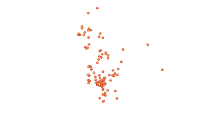

In [312]:
gardens_dataset = gis.content.get('0244bc340835484cb01441dda6b9d46b')
gardens_dataset

In [313]:
# here in the data we can see there are only 4 columns (including the shape)
# we will add supplementary data using geoenrichment soon
gardens = gardens_dataset.layers[0].query(out_sr=4326).sdf
gardens.head()

,FID,POINT_X,POINT_Y,SHAPE
0,1,-117.033671,32.656749,"{""x"": -117.03367108099995, ""y"": 32.65674940700..."
1,2,-117.064134,32.631579,"{""x"": -117.06413399999998, ""y"": 32.63157900000..."
2,3,-117.084920,32.619395,"{""x"": -117.08491983199998, ""y"": 32.61939466500..."
3,4,-117.080262,32.615775,"{""x"": -117.08026199999996, ""y"": 32.61577500000..."
4,5,-117.060825,32.608372,"{""x"": -117.06082509499998, ""y"": 32.60837228200..."


In [314]:
gardens.shape

(97, 4)

In [315]:
def enrich_data(df):
    '''takes in a dataframe and merges it with the geoenriched data, in this case, householdincome'''
    out_df = None
    is_first = True
    df['merge_col'] = list(df.index)
    for i in df.index:
        # miles radius for each buffer computed for each garden
        radius_vals = [3,5,7]
        # creates buffers of 3, 5, and 7 miles radius around each garden
        buffered = BufferStudyArea(area=df.loc[i].SHAPE, radii=[3,5,7], units='Miles', overlap=False)
        # enriches data, aka gets new features corresponding to each buffer, does this for all the buffers
        enrich_df = enrich(study_areas=[buffered], data_collections=['householdincome', '2020'])
        
        # combining data
        enrich_df['merge_col'] = [i] * len(radius_vals)
        temp_df = enrich_df.merge(df[df.index == i], left_on = 'merge_col', right_on = 'merge_col', how = 'inner')
        
        # first run, create df
        if is_first:
            out_df = pd.DataFrame(columns = temp_df.columns)
            out_df = pd.concat([out_df, temp_df], ignore_index=True)
            is_first = False
        else: # concatenate existing df with new df just generated
            out_df = pd.concat([out_df, temp_df], ignore_index=True)
    return out_df

In [316]:
gardens_geoenrich = enrich_data(gardens)
gardens_geoenrich

,ID,OBJECTID,sourceCountry,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,...,PCI_FY,AGGINC_FY,AGGHINC_FY,HINCBASEFY,SHAPE_x,merge_col,FID,POINT_X,POINT_Y,SHAPE_y
0,0,1,US,RingBufferBands,Miles,Miles,3,BlockApportionment:US.BlockGroups,2.191,2.576,...,34853,5430415905,5420361709,47388,"{'rings': [[[-117.03367108099995, 32.700284988...",0,1,-117.033671,32.656749,"{'x': -117.03367108099995, 'y': 32.65674940700..."
1,0,2,US,RingBufferBands,Miles,Miles,5,BlockApportionment:US.BlockGroups,2.191,2.576,...,26730,9250786023,9242523364,99731,"{'rings': [[[-117.03367108099995, 32.729308541...",0,1,-117.033671,32.656749,"{'x': -117.03367108099995, 'y': 32.65674940700..."
2,0,3,US,RingBufferBands,Miles,Miles,7,BlockApportionment:US.BlockGroups,2.191,2.576,...,27276,8699816807,8298470830,89419,"{'rings': [[[-117.03367108099995, 32.758331959...",0,1,-117.033671,32.656749,"{'x': -117.03367108099995, 'y': 32.65674940700..."
3,0,1,US,RingBufferBands,Miles,Miles,3,BlockApportionment:US.BlockGroups,2.191,2.576,...,27352,5060915270,5058441282,57428,"{'rings': [[[-117.06413399999998, 32.675114756...",1,2,-117.064134,32.631579,"{'x': -117.06413399999998, 'y': 32.63157900000..."
4,0,2,US,RingBufferBands,Miles,Miles,5,BlockApportionment:US.BlockGroups,2.191,2.576,...,28121,8549171325,8273106644,84476,"{'rings': [[[-117.06413399999998, 32.704138425...",1,2,-117.064134,32.631579,"{'x': -117.06413399999998, 'y': 32.63157900000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,0,2,US,RingBufferBands,Miles,Miles,5,BlockApportionment:US.BlockGroups,2.191,2.576,...,40517,3236055549,3252904915,22435,"{'rings': [[[-116.93254049999996, 32.654414001...",95,96,-116.932541,32.581854,"{'x': -116.93254049999996, 'y': 32.58185400000..."
287,0,3,US,RingBufferBands,Miles,Miles,7,BlockApportionment:US.BlockGroups,2.191,2.576,...,35331,4318048775,4273850064,33981,"{'rings': [[[-116.93254049999996, 32.683437766...",95,96,-116.932541,32.581854,"{'x': -116.93254049999996, 'y': 32.58185400000..."
288,0,1,US,RingBufferBands,Miles,Miles,3,BlockApportionment:US.BlockGroups,2.191,2.576,...,27457,855395445,843042768,8907,"{'rings': [[[-117.323304485, 33.74530269810875...",96,97,-117.323304,33.701774,"{'x': -117.323304485, 'y': 33.70177443700003, ..."
289,0,2,US,RingBufferBands,Miles,Miles,5,BlockApportionment:US.BlockGroups,2.191,2.576,...,28654,2001572705,2014114484,21001,"{'rings': [[[-117.323304485, 33.77432136808247...",96,97,-117.323304,33.701774,"{'x': -117.323304485, 'y': 33.70177443700003, ..."


# Data Cleaning

Steps for data cleaning:
 - understand the columns in the enriched dataset
 - rename the cryptic column names in the dataset by looking up the alias 
 - drop columns with information about 2025, only retain cols with 2020
 - verify the fidelity of the enriched income columns by plotting histograms and calculating summary statistics
 - no null values in this dataset (awesome!), and the number of households per income bracket follow a fairly normal distribution; searched up the distribution of wealth in the US and it looks very similar --> I trust this data


Dropped redudnant columns and those with the same values throughout all observations

In [317]:
# dropping
gardens_geoenrich = gardens_geoenrich.drop(['OBJECTID', 'ID', 'merge_col','POINT_X','POINT_Y',
                                            'aggregationMethod', 'populationToPolygonSizeRating',
                                            'apportionmentConfidence'], axis = 1)
# renaming
gardens_geoenrich = gardens_geoenrich.rename(columns = {'SHAPE_x':'SHAPE', 'SHAPE_y':'POINT_SHAPE'})
gardens_geoenrich.head()

,sourceCountry,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,HasData,HINC0_CY,HINC15_CY,HINC25_CY,HINC35_CY,...,HINC200_FY,MEDHINC_FY,AVGHINC_FY,PCI_FY,AGGINC_FY,AGGHINC_FY,HINCBASEFY,SHAPE,FID,POINT_SHAPE
0,US,RingBufferBands,Miles,Miles,3,1,2730,2404,2994,4735,...,4455,90974,114383,34853,5430415905,5420361709,47388,"{'rings': [[[-117.03367108099995, 32.700284988...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
1,US,RingBufferBands,Miles,Miles,5,1,9075,8548,8283,12551,...,6115,69618,92675,26730,9250786023,9242523364,99731,"{'rings': [[[-117.03367108099995, 32.729308541...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
2,US,RingBufferBands,Miles,Miles,7,1,7897,7572,7961,11542,...,6013,67525,92804,27276,8699816807,8298470830,89419,"{'rings': [[[-117.03367108099995, 32.758331959...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
3,US,RingBufferBands,Miles,Miles,3,1,5349,5044,5157,7852,...,2952,65430,88083,27352,5060915270,5058441282,57428,"{'rings': [[[-117.06413399999998, 32.675114756...",2,"{'x': -117.06413399999998, 'y': 32.63157900000..."
4,US,RingBufferBands,Miles,Miles,5,1,7102,6155,6544,9937,...,5704,75973,97934,28121,8549171325,8273106644,84476,"{'rings': [[[-117.06413399999998, 32.704138425...",2,"{'x': -117.06413399999998, 'y': 32.63157900000..."


In [318]:
# aspects of the data collection service where I got my dataset from (through ArcGIS)
usa = Country.get('US')
usa.properties.datasets
data_col = usa.data_collections
print(data_col.index.unique().values)
data_col

['1yearincrements' '5yearincrements' 'ACS_Housing_Summary_rep'
 'ACS_Population_Summary_rep' 'Age' 'AgeDependency' 'Age_50_Profile_rep'
 'Age_by_Sex_Profile_rep' 'Age_by_Sex_by_Race_Profile_rep' 'AtRisk'
 'AutomobilesAutomotiveProducts' 'Automotive_Aftermarket_Expenditures_rep'
 'BabyProductsToysGames' 'Business_Summary_rep'
 'CivicActivitiesPoliticalAffiliation' 'ClothingShoesAccessories'
 'Community_Profile_rep' 'DaytimePopulation'
 'Demographic_and_Income_Comparison_Profile_rep'
 'Demographic_and_Income_Profile_rep' 'Disposable_Income_Profile_rep'
 'ElectronicsInternet' 'Electronics_and_Internet_Market_Potential_rep'
 'EmploymentUnemployment' 'Executive_Summary_rep'
 'Finances_Market_Potential_rep' 'FinancialInsurance'
 'Financial_Expenditures_rep' 'Generations' 'Graphic_Profile_rep'
 'GroceryAlcoholicBeverages' 'Health' 'HealthPersonalCare'
 'HealthPersonalCareCEX' 'Health_and_Beauty_Market_Potential_rep'
 'HistoricalHouseholds' 'HistoricalHousing' 'HistoricalPopulation'
 'HomeImpr

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2020 Population Age <1,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE1_CY,2020 Population Age 1,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE2_CY,2020 Population Age 2,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE3_CY,2020 Population Age 3,2020 Age: 1 Year Increments (Esri),2020
1yearincrements,1yearincrements.AGE4_CY,2020 Population Age 4,2020 Age: 1 Year Increments (Esri),2020
...,...,...,...,...
yearmovedin,yearmovedin.MOEMEDYRMV,2018 Median Year Householder Moved In MOE (ACS...,2014-2018 Year Householder Moved In (ACS),2014-2018
yearmovedin,yearmovedin.RELMEDYRMV,2018 Median Year Householder Moved In REL (ACS...,2014-2018 Year Householder Moved In (ACS),2014-2018
yearmovedin,yearmovedin.ACSOWNER,2018 Owner Households (ACS 5-Yr),2014-2018 Key Demographic Indicators (ACS),2014-2018


In [319]:
gardens_geoenrich.HasData.value_counts()

1    291
Name: HasData, dtype: int64

In [320]:
def better_col_names(df, data_col):
    '''returns column names that are more descriptive'''
    out_lst = []
    for col in df.columns:
        try:
            item = data_col[data_col['analysisVariable'].str.contains(col)].alias[1]
            out_lst.append(item)
        except:
            out_lst.append(col)
    return out_lst

In [321]:
new_cols = better_col_names(gardens_geoenrich, data_col)
len(new_cols)

41

In [322]:
len(gardens_geoenrich.columns)

41

In [323]:
gardens_geoenrich.columns = new_cols
gardens_geoenrich.head()

,sourceCountry,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,HasData,2020 HH Income <$15000,2020 HH Income $15000-24999,2020 HH Income $25000-34999,2020 HH Income $35000-49999,...,2025 HH Income $200000+,2025 Median Household Income,2025 Average Household Income,2025 Per Capita Income,2025 Aggregate Income,2025 Aggregate HH Income,2025 Households by Income Base,SHAPE,FID,POINT_SHAPE
0,US,RingBufferBands,Miles,Miles,3,1,2730,2404,2994,4735,...,4455,90974,114383,34853,5430415905,5420361709,47388,"{'rings': [[[-117.03367108099995, 32.700284988...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
1,US,RingBufferBands,Miles,Miles,5,1,9075,8548,8283,12551,...,6115,69618,92675,26730,9250786023,9242523364,99731,"{'rings': [[[-117.03367108099995, 32.729308541...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
2,US,RingBufferBands,Miles,Miles,7,1,7897,7572,7961,11542,...,6013,67525,92804,27276,8699816807,8298470830,89419,"{'rings': [[[-117.03367108099995, 32.758331959...",1,"{'x': -117.03367108099995, 'y': 32.65674940700..."
3,US,RingBufferBands,Miles,Miles,3,1,5349,5044,5157,7852,...,2952,65430,88083,27352,5060915270,5058441282,57428,"{'rings': [[[-117.06413399999998, 32.675114756...",2,"{'x': -117.06413399999998, 'y': 32.63157900000..."
4,US,RingBufferBands,Miles,Miles,5,1,7102,6155,6544,9937,...,5704,75973,97934,28121,8549171325,8273106644,84476,"{'rings': [[[-117.06413399999998, 32.704138425...",2,"{'x': -117.06413399999998, 'y': 32.63157900000..."


In [324]:
# dropping all columns not in 2020
drop_cols = []
for col in gardens_geoenrich.columns:
    if '2025' in col:
        drop_cols.append(col)
        
gardens_geoenrich = gardens_geoenrich.drop(drop_cols, axis =1)

In [325]:
gardens_geoenrich.columns

Index(['sourceCountry', 'areaType', 'bufferUnits', 'bufferUnitsAlias',
       'bufferRadii', 'HasData', '2020 HH Income <$15000',
       '2020 HH Income $15000-24999', '2020 HH Income $25000-34999',
       '2020 HH Income $35000-49999', '2020 HH Income $50000-74999',
       '2020 HH Income $75000-99999', '2020 HH Income $100000-149999',
       '2020 HH Income $150000-199999', '2020 HH Income $200000+',
       '2020 Median Household Income', '2020 Average Household Income',
       '2020 Per Capita Income', '2020 Aggregate Income',
       '2020 Aggregate HH Income', '2020 Households by Income Base', 'SHAPE',
       'FID', 'POINT_SHAPE'],
      dtype='object')

In [326]:
# for easier naming purposes
gardens = gardens_geoenrich 

In [327]:
gardens.HasData.isnull().sum()

0

In [405]:
# general EDA histograms

(0.0, 15001.0)

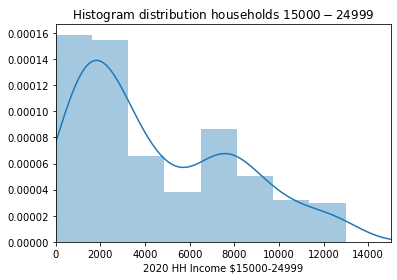

In [328]:
ax = sns.distplot(gardens['2020 HH Income $15000-24999'])
ax.set_title('Histogram distribution households $15000-$24999')
ax.set_xlim(0,15001, 4000)

(0.0, 16001.0)

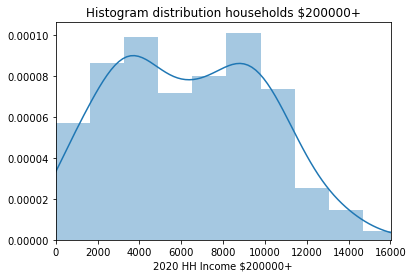

In [329]:
ax = sns.distplot(gardens['2020 HH Income $200000+'])
ax.set_title('Histogram distribution households $200000+')
ax.set_xlim(0,16001, 2500)

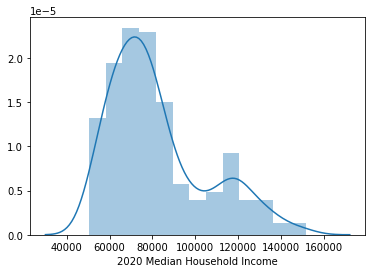

In [330]:
ax = sns.distplot(gardens['2020 Median Household Income'])

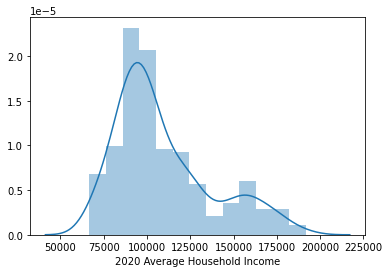

In [331]:
ax = sns.distplot(gardens['2020 Average Household Income'])

In [333]:
np.median(gardens['2020 Median Household Income'])

76520.0

# Feature Engineering

My rationale for deciding the bins for the low, moderate, and high income bins are to declare the moderate income bin to be bounded by 1 standard deviation in each direction of the median. This is to encompass the idea of a "middle class", and this method reflects the distribution of wealth classes throughout America. Low income is defined as incomes less than the beginning bound of the moderate income, and high income defined as incomes greater than the moderate income ending bound. For the sake of this study, I use round the bounds to be able to utilize columns easily.
- Median: 72,088
- St. Dev: 26,023
- Low Income: 0 - 49,999 dollars
- Moderate Income: 50,000 - 99,999 dollars
- High Income: 100,000+ dollars

In [334]:
gardens['low_income'] = (gardens['2020 HH Income <$15000'] + gardens['2020 HH Income $15000-24999'] + 
                        gardens['2020 HH Income $25000-34999'] + gardens['2020 HH Income $35000-49999'])
gardens['moderate_income'] = (gardens['2020 HH Income $50000-74999'] + gardens['2020 HH Income $75000-99999'])
gardens['high_income'] = (gardens['2020 HH Income $100000-149999'] + gardens['2020 HH Income $150000-199999'] + 
                              gardens['2020 HH Income $200000+'])

total_num = gardens['low_income'] + gardens['moderate_income'] + gardens['high_income']
gardens['low_income_proportion'] = gardens['low_income'] / total_num
gardens['moderate_income_proportion'] = gardens['moderate_income'] / total_num
gardens['high_income_proportion'] = gardens['high_income'] / total_num

In [335]:
gardens.head()

,sourceCountry,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,HasData,2020 HH Income <$15000,2020 HH Income $15000-24999,2020 HH Income $25000-34999,2020 HH Income $35000-49999,...,2020 Households by Income Base,SHAPE,FID,POINT_SHAPE,low_income,moderate_income,high_income,low_income_proportion,moderate_income_proportion,high_income_proportion
0,US,RingBufferBands,Miles,Miles,3,1,2730,2404,2994,4735,...,47049,"{'rings': [[[-117.03367108099995, 32.700284988...",1,"{'x': -117.03367108099995, 'y': 32.65674940700...",12863,15210,18976,0.273396,0.32328,0.403324
1,US,RingBufferBands,Miles,Miles,5,1,9075,8548,8283,12551,...,97700,"{'rings': [[[-117.03367108099995, 32.729308541...",1,"{'x': -117.03367108099995, 'y': 32.65674940700...",38457,29991,29252,0.393623,0.30697,0.299406
2,US,RingBufferBands,Miles,Miles,7,1,7897,7572,7961,11542,...,87463,"{'rings': [[[-117.03367108099995, 32.758331959...",1,"{'x': -117.03367108099995, 'y': 32.65674940700...",34972,27336,25154,0.399854,0.312547,0.287599
3,US,RingBufferBands,Miles,Miles,3,1,5349,5044,5157,7852,...,56594,"{'rings': [[[-117.06413399999998, 32.675114756...",2,"{'x': -117.06413399999998, 'y': 32.63157900000...",23402,17923,15269,0.413507,0.316694,0.269799
4,US,RingBufferBands,Miles,Miles,5,1,7102,6155,6544,9937,...,82977,"{'rings': [[[-117.06413399999998, 32.704138425...",2,"{'x': -117.06413399999998, 'y': 32.63157900000...",29738,26571,26668,0.358388,0.320221,0.32139


# Data Analysis & Results


Steps:
1. Look at the percentage of high income households in a community and how it compares to the national average (31.4%)
2. Calculate p-value to answer: Is there a statistically significant difference in the values?
3. How does that compare the farther and farther you get from the garden commmunity?

In [ ]:
# look at the percentage of households in a community and how it compares to the national average (31.4%)
# is there a statistically significant difference in the values?
# calculate p-value
# how does that compare the farther and farther you get from the garden commmunity?
# is this distance reasonable?

# High Income Households

[Text(0.5, 0, ' proportion of high income households')]

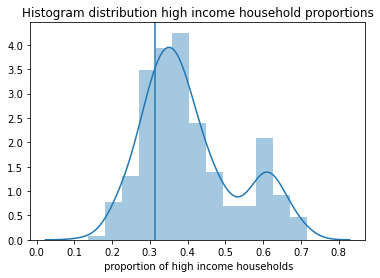

In [339]:
ax = sns.distplot(gardens.high_income_proportion)
ax.axvline(0.314, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution high income household proportions')
ax.set(xlabel=' proportion of high income households') # histogram, so y-axis can be left unlabeled

[Text(0.5, 0, ' proportion of high income households')]

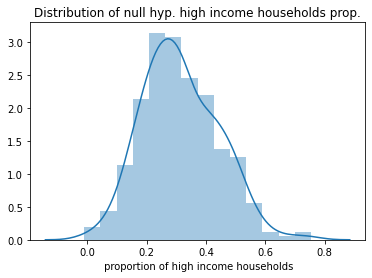

In [348]:
# distribution generated under the null hypothesis
mu, sigma = 0.314, 0.125 # mean and standard deviation
s = np.random.normal(mu, sigma, 291) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. high income households prop.')
ax.set(xlabel=' proportion of high income households')

In [349]:
norm_test = normaltest(gardens.high_income_proportion)[1]
norm_test # p-value

1.8400758061940023e-05

Utilizing a normal test, we can observe that the high income proportion gets a p-value of 0.0013, which is less than 5% accepted p-value threshold. Thus, we can claim that the distribution observed is not a normal distribution. We have to use something other than a t-test.

In [352]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens.high_income_proportion)
p_val

5.029946868796052e-14

A p-value of 0.000269 is much less than the accepted threshold of 5%. Therefore, we reject the null hypothesis in favor of the alternative.

Same analysis as above, but segmenting it into the different buffer sizes

In [351]:
# three mile buffers
gardens_three = gardens[gardens['bufferRadii'] == 3]

[Text(0.5, 0, ' proportion of high income households')]

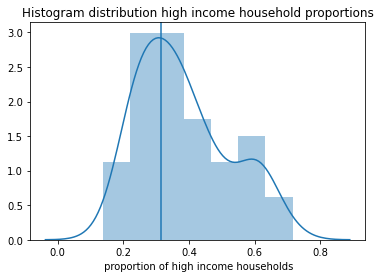

In [354]:
ax = sns.distplot(gardens_three.high_income_proportion)
ax.axvline(0.314, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution high income household proportions')
ax.set(xlabel=' proportion of high income households') # histogram, so y-axis can be left unlabeled
# plotting moderate income proportion

[Text(0.5, 0, ' proportion of high income households')]

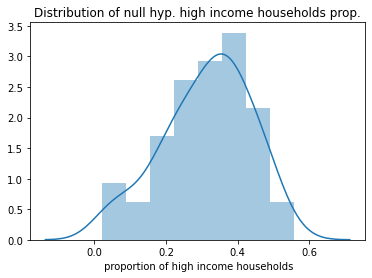

In [355]:
# distribution generated under the null hypothesis
mu, sigma = 0.314, 0.125 # mean and standard deviation
s = np.random.normal(mu, sigma, 97) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. high income households prop.')
ax.set(xlabel=' proportion of high income households')

In [357]:
norm_test = normaltest(gardens_three.high_income_proportion)[1]
norm_test # p-value shows not normal distribution at 5% threshhold

0.013547366562957682

In [359]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens_three.high_income_proportion)
p_val

0.002158614067610744

Once again, reject the null in favor of the alternative for three mile buffers

In [360]:
# five mile buffers
gardens_five = gardens[gardens['bufferRadii'] == 5]

[Text(0.5, 0, ' proportion of high income households')]

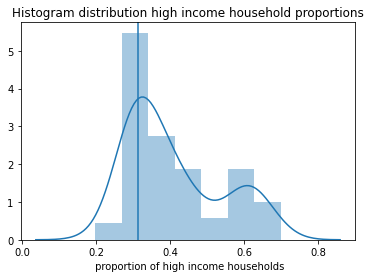

In [361]:
ax = sns.distplot(gardens_five.high_income_proportion)
ax.axvline(0.314, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution high income household proportions')
ax.set(xlabel=' proportion of high income households') # histogram, so y-axis can be left unlabeled
# plotting moderate income proportion

[Text(0.5, 0, ' proportion of high income households')]

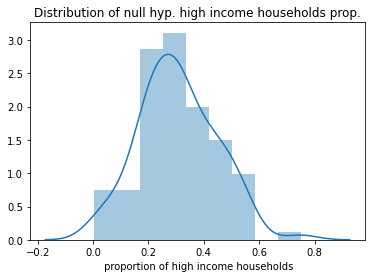

In [362]:
# distribution generated under the null hypothesis
mu, sigma = 0.314, 0.125 # mean and standard deviation
s = np.random.normal(mu, sigma, 97) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. high income households prop.')
ax.set(xlabel=' proportion of high income households')

In [363]:
norm_test = normaltest(gardens_five.high_income_proportion)[1]
norm_test # p-value shows not normal distribution at 5% threshhold

0.0013172025601777793

In [364]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens_five.high_income_proportion)
p_val

1.2218426059283523e-05

Once again, reject the null in favor of the alternative for five mile buffers

In [365]:
# seven mile buffers
gardens_seven = gardens[gardens['bufferRadii'] == 7]

[Text(0.5, 0, ' proportion of high income households')]

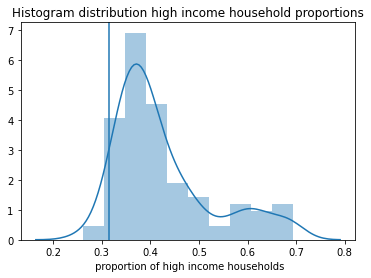

In [366]:
ax = sns.distplot(gardens_seven.high_income_proportion)
ax.axvline(0.314, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution high income household proportions')
ax.set(xlabel=' proportion of high income households') # histogram, so y-axis can be left unlabeled
# plotting moderate income proportion

[Text(0.5, 0, ' proportion of high income households')]

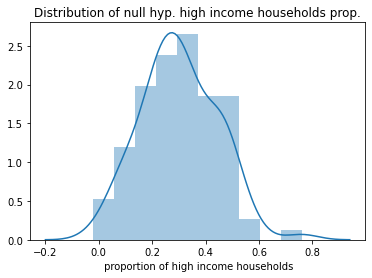

In [367]:
# distribution generated under the null hypothesis
mu, sigma = 0.314, 0.125 # mean and standard deviation
s = np.random.normal(mu, sigma, 97) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. high income households prop.')
ax.set(xlabel=' proportion of high income households')

In [368]:
norm_test = normaltest(gardens_seven.high_income_proportion)[1]
norm_test # p-value shows not normal distribution at 5% threshhold

3.8694984721131926e-05

In [369]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens_seven.high_income_proportion)
p_val

5.278845294193604e-09

# Moderate Income Households

In [ ]:
# looking at moderate income households
# natl average = 28.8% of all households

[Text(0.5, 0, ' proportion of high income households')]

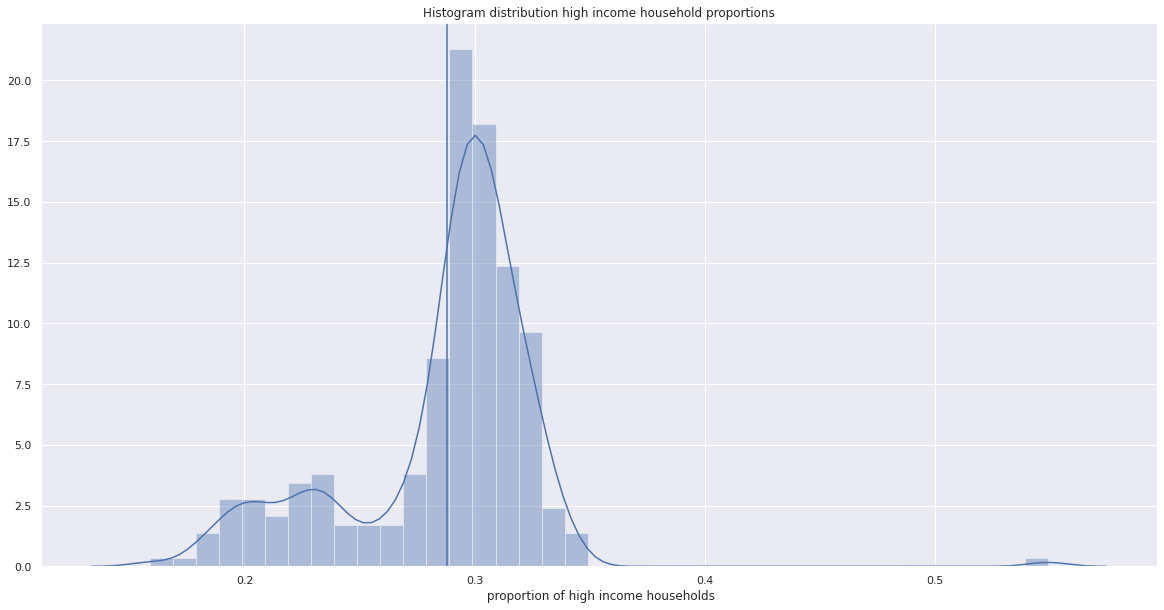

In [407]:
ax = sns.distplot(gardens.moderate_income_proportion)
ax.axvline(0.288, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution moderate income household proportions')
ax.set(xlabel=' proportion of moderate income households') # histogram, so y-axis can be left unlabeled

[Text(0.5, 0, ' proportion of moderate income households')]

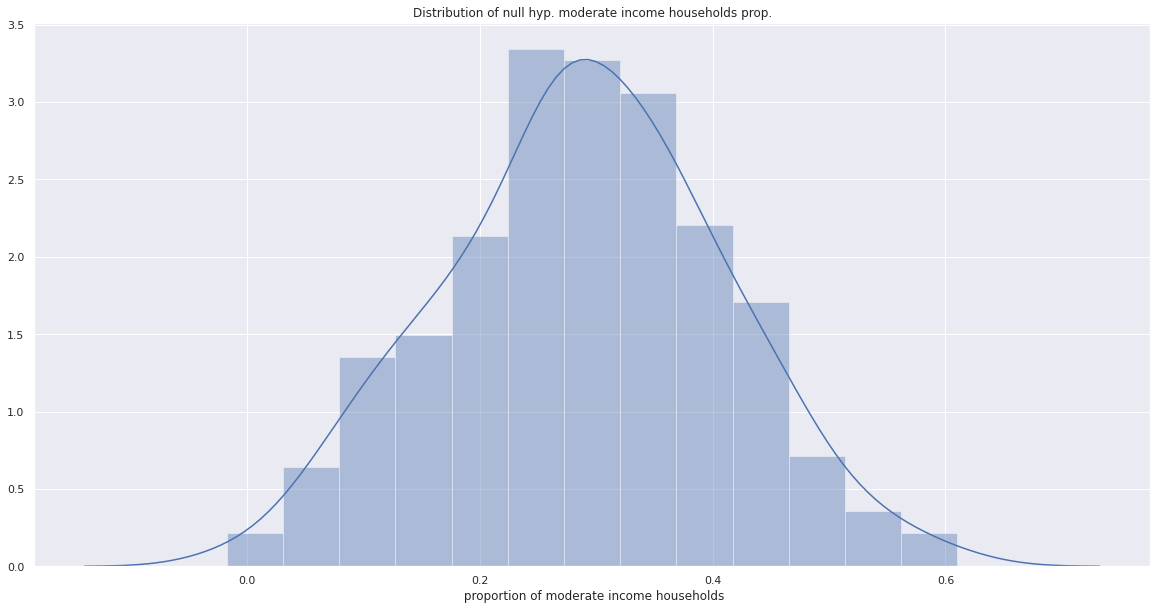

In [408]:
# distribution generated under the null hypothesis
mu, sigma = 0.288, 0.12 # mean and standard deviation
s = np.random.normal(mu, sigma, 291) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. moderate income households prop.')
ax.set(xlabel=' proportion of moderate income households')

In [409]:
norm_test = normaltest(gardens.moderate_income_proportion)[1]
norm_test # p-value

3.9234568074662396e-10

Utilizing a normal test, we can observe that the moderate income proportion gets a tiny p-value, which is less than 5% accepted p-value threshold. Thus, we can claim that the distribution observed is not a normal distribution. We have to use something other than a t-test.

In [410]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens.moderate_income_proportion)
p_val

0.5691120572991057

A p-value of 0.569 means that we do not reject the null hypothesis. This means that the moderate income household proportion is reflective of the distribution of moderate income household proportions generated utilizing the national average statistics.

# Low Income Households

In [ ]:
# low income household analysis
# low income natl statistic = 37.1%

[Text(0.5, 0, ' proportion of low income households')]

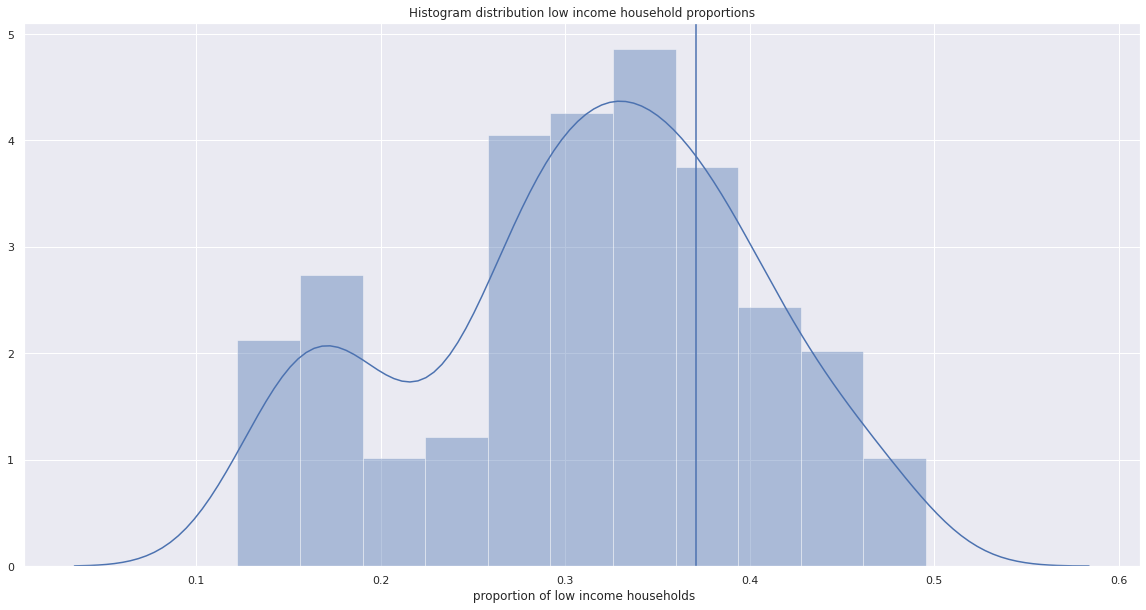

In [412]:
ax = sns.distplot(gardens.low_income_proportion)
ax.axvline(0.371, 0,1) # plotting high income national percentage as a vertical line
ax.set_title('Histogram distribution low income household proportions')
ax.set(xlabel=' proportion of low income households') # histogram, so y-axis can be left unlabeled

[Text(0.5, 0, ' proportion of low income households')]

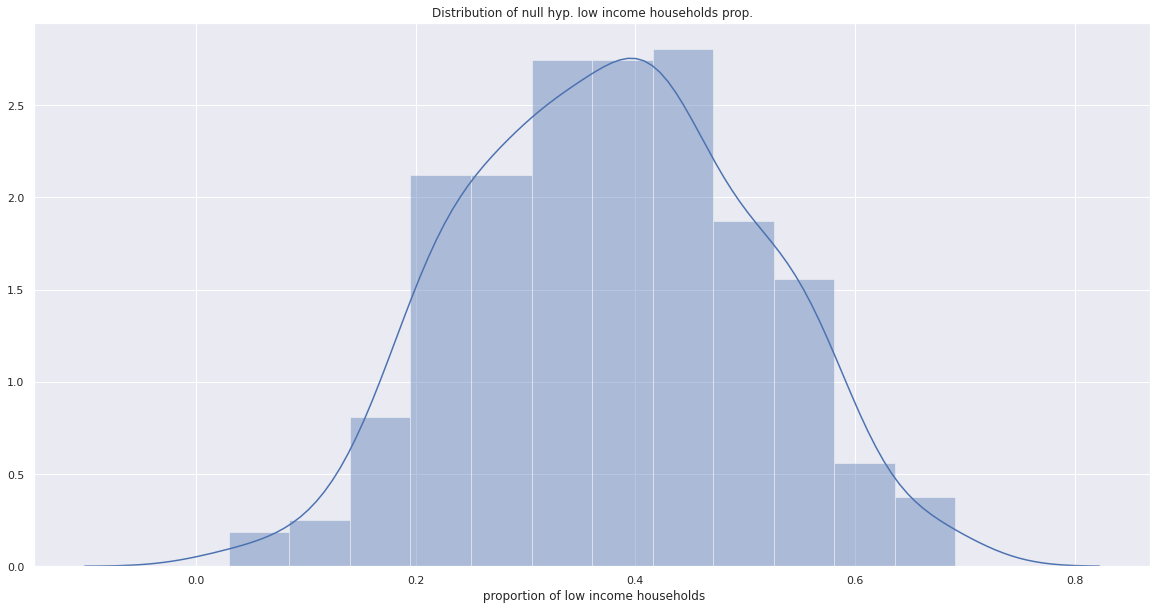

In [413]:
# distribution generated under the null hypothesis
mu, sigma = 0.371, 0.12 # mean and standard deviation
s = np.random.normal(mu, sigma, 291) # size = 291 because size of dataset
ax = sns.distplot(s)
ax.set_title('Distribution of null hyp. low income households prop.')
ax.set(xlabel=' proportion of low income households')

In [414]:
norm_test = normaltest(gardens.low_income_proportion)[1]
norm_test # p-value

0.0002705859639129787

Utilizing a normal test, we can observe that the moderate income proportion gets a tiny p-value, which is less than 5% accepted p-value threshold. Thus, we can claim that the distribution observed is not a normal distribution. We have to use something other than a t-test.

In [415]:
# one sample sign test used instead of t-test because observed distribution not normal
t_val, p_val = wilcoxon(s, gardens.low_income_proportion)
p_val

4.5633687833186827e-11

A tiny p-value means that we do reject the null hypothesis in favor of the alternative. This means that the low income household proportion is not reflective of the distribution of low income household proportions generated utilizing the national average statistics. Based on visualizations, it would seem that there are less low income households near San Diego Parks.

Takeaway: At all buffer sizes, we see that high income households are disproportionately closer to the gardens than what we would observe under the assumption that the proportion of households around gardens are reflective of the national proportion of high income households. As you increase the buffer size (radius around the gardens), we see that the proportion of high income households gets more and more disproportionate. There is a larger and larger high income household proportion as you increase the buffer size. The proportion of moderate income households near San Diego Parks is similar to what we would expect given the national average. The proportion of low income households near San Diego Parks is disproportionately less than what we might have expected given the national average.

## Visualizations

In [372]:
# Disclaimer: Because this is a map that is adjustable in live time, I cannot add a title
# Title: San Diego Garden Locations
gardens_viz = gardens_dataset.layers[0].query(out_sr=4326).sdf
map1 = gis.map('San Diego, CA')
map1.add_layer(gardens_viz)
map1

MapView(layout=Layout(height='400px', width='100%'))

In [371]:
eq15 = use_proximity.create_buffers(gardens_dataset.layers[0], distances=[5], units = 'Miles', dissolve_type = 'Dissolve')

In [373]:
# Title: Buffers around SD gardens of 5 mile radius
map2 = gis.map('San Diego, CA')
map2.add_layer(eq15)
map2

MapView(layout=Layout(height='400px', width='100%'))

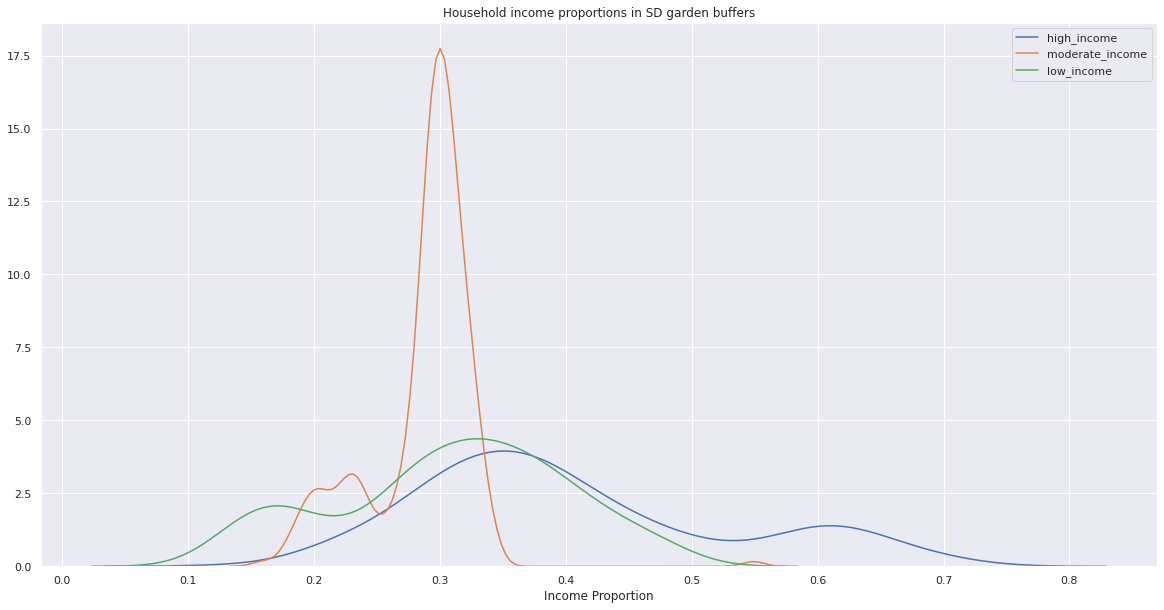

In [404]:
arr1 = sns.distplot(gardens['high_income_proportion'],label='high_income', hist = False)
arr2 = sns.distplot(gardens['moderate_income_proportion'], label='moderate_income', hist = False)
arr3 = sns.distplot(gardens['low_income_proportion'], label='low_income', hist = False)
arr3.set_title('Household income proportions in SD garden buffers')
arr3.set(xlabel='Income Proportion')
sns.set(rc={'figure.figsize':(20,10)})

In [416]:
# Key takeaways from plot: high income household proportions are very high considering its relation to the national
# average as well as to other income brackets
# low income is disproportionately low, and moderate income is what we might expect

# Ethics & Privacy

The ethics of doing this kind of analysis are always pivotol. This analysis can be used in facilitating the building of community gardens in different locations, obviously bringing in implications for people whose location would have been chosen preanalysis and implications for people who location would have been chosen postanalysis. Possible consequences can be the increase in thought that the result of this analysis will be unfair to a particular gorup of people (most likely high income households). This might put strain on the city and overall increase tensions between the city government and the city residents. With that being said, if a planner is looking to place a garden in a location that best represents the US's income distribution, this would be a strictly fair approach. This is against the status quo however, and will proabably envoke some outrage. In regards to privacy, the information used through geoenrichment is attained from ArcGIS' data collections (I am unsure how it was exactly collected). Knowing this information and knowing the general perception of an area's income distribution may and will make people uncomfortable. This is doubly important because government data such as census information is confidential, so having information that would normally be gathered through a census and would be confidential become essentially public is concerning.

# Conclusion & Discussion

In conclusion, there is a disproportionate amount of high income households around San Diego gardens. By performing a one sample sign test, we were able to uncover a very low p-value, indicating that the distribution observed around SD gardens was very different than the distribution generated by the national average proportions. Thus, we go in favor of the alternative hypothesis which states that SD gardens are placed in loacations closer to higher income households. The limitation and hesitation about coming to this conclusion is that I am assuming that San Diego's income distribution is representative of the national income distribution. This may not be entirely true. This is a limitation because I was unable to successfully track the distribution of income in San Diego. I used national average numbers instead. <b>So, there is a disporportionate amount of high income households around San Diego gardens assuming that the San Diego income distribution is representative of the natinoal income distribution. Using this same assumption, there is a proportionate amount of moderate income households around SD gardens, and a disproportionately low amount of low income households around SD gardens.</b> Additional limitations include being unable to geoenrich the names of the parks using geometry (was not working for some reason) as well as being unable to extrapolate to other cities (this is an SD specific study). One thing to note is that I did choose a fair number of arbitrary thresholds and I did make key assumptions (such as bin bounds and standard deviations) during this analysis. In conclusion, my analysis supports my initial hypothesis.

Future steps: Future analysis would include performing location allocation (choosing where to put future, prospective gardens). This requires a LOT of work including publishing a multitide of layers and picking by hand prospective and suitable locations for parks. An easier and still effective method would be to compute some sort of suitability analysis utilizing rasters, and overlay that map with the map of income distribution, and choose a location that is both suitable and fair.